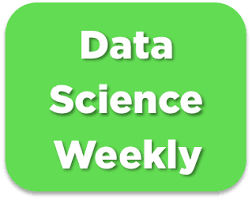

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import datasets
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import feature_extraction
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import display

# Read file with labels

In [5]:
data_init = pd.read_csv(r'G:\Mon Drive\Fichiers\2.Scolarité\1. Jedha_Data_Science\PROJETS\04_SUPERVISED_ML\Conversion rate\csv_conversion_data_train.csv')


In [6]:
data_init.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [16]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
#stratify ???
data_sample = data_init.sample(10_000)

In [17]:
print("general info : ")
display(data_sample.info())
print()

print("Number of rows : {}".format(data_sample.shape[0]))
print()

print("Display of dataset: ")
display(data_sample.head())
print()

print("Basics statistics: ")
data_desc = data_sample.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data_sample.isnull().sum()/data_sample.shape[0])

general info : 
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 247324 to 204538
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              50000 non-null  object
 1   age                  50000 non-null  int64 
 2   new_user             50000 non-null  int64 
 3   source               50000 non-null  object
 4   total_pages_visited  50000 non-null  int64 
 5   converted            50000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


None


Number of rows : 50000

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
247324,US,31,0,Seo,4,0
133652,US,30,0,Seo,2,0
271586,UK,23,1,Ads,6,0
5875,US,17,1,Seo,7,0
202638,UK,41,1,Seo,5,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,50000,50000.00000,50000.000000,50000,50000.000000,50000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,28360,NaN,NaN,24420,NaN,NaN
mean,NaN,30.54816,0.688460,NaN,4.872440,0.032700
std,NaN,8.23798,0.463128,NaN,3.345605,0.177852
min,NaN,17.00000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.00000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.00000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.00000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [18]:
data_sample['converted'].value_counts()

converted
0    48365
1     1635
Name: count, dtype: int64

In [19]:
print("Separating labels from features...")
target_variable = "converted"

X = data_sample.drop(target_variable, axis = 1)
Y = data_sample.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

numeric_features = list(X.select_dtypes(include=['float', 'int']).columns)
categorical_features = list(X.select_dtypes(exclude=['float', 'int']).columns)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Separating labels from features...
...Done.

Y : 
247324    0
133652    0
271586    0
5875      0
202638    0
Name: converted, dtype: int64

X :
       country  age  new_user source  total_pages_visited
247324      US   31         0    Seo                    4
133652      US   30         0    Seo                    2
271586      UK   23         1    Ads                    6
5875        US   17         1    Seo                    7
202638      UK   41         1    Seo                    5
Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


In [20]:
# Distribution of each numeric variable
for f in numeric_features:
    fig = px.histogram(data_sample, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()

In [21]:
# Distribution of each categorical variable

for i in range(len(categorical_features)):
    fig = px.histogram(data_sample[categorical_features[i]])
    fig.show()

In [22]:
## Correlation matrix

corr_matrix = data_sample.corr(numeric_only = True).round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

# Make your model

## Choose variables to use in the model, and create train and test sets


In [23]:
print("Separating labels from features...")
target_variable = "converted"

X = data_sample.drop(target_variable, axis = 1)
Y = data_sample.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
247324    0
133652    0
271586    0
5875      0
202638    0
Name: converted, dtype: int64

X :
       country  age  new_user source  total_pages_visited
247324      US   31         0    Seo                    4
133652      US   30         0    Seo                    2
271586      UK   23         1    Ads                    6
5875        US   17         1    Seo                    7
202638      UK   41         1    Seo                    5


In [24]:
# Divide dataset Train set & Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

...Done.



In [25]:
# Identificate the column data type

numeric_features = list(X.select_dtypes(include=['float', 'int']).columns)
categorical_features = list(X.select_dtypes(exclude=['float', 'int']).columns)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'new_user', 'total_pages_visited']
Found categorical features  ['country', 'source']


## Training pipeline

In [26]:
numeric_transformer = Pipeline(
    steps=[ #liste de 2 tuples
        ("scaler",  StandardScaler()),  # put data of the column on scale for all columns where mean = 0, and value = std
    ]
)

## Create pipeline for columns with categorical features
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first")),  # first column will be dropped to avoid creating correlations between features
    ]
)

## Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done to the columns group selected
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

## Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

## Encoding Y on train set (if Y is categorical in this example)
print("Encoding labels...")
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Encoding Y on test set
print("Encoding labels...")
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
...Done.
[[ 0.18130834  0.67106358  0.3375379   0.          0.          0.
   0.          1.        ]
 [-0.79106617  0.67106358 -0.56102562  0.          0.          1.
   0.          1.        ]
 [ 0.78904241  0.67106358 -0.56102562  0.          1.          0.
   0.          1.        ]
 [ 0.42440197 -1.49017177  0.03801672  0.          0.          1.
   0.          1.        ]
 [ 0.6674956  -1.49017177 -0.86054679  0.          0.          0.
   0.          1.        ]]

Performing preprocessings on test set...
...Done.
[[ 1.63987011  0.67106358  0.03801672  0.          0.          1.
   0.          1.        ]
 [ 0.05976153  0.67106358 -1.16006796  0.          0.          1.
   0.          1.        ]
 [ 0.42440197 -1.49017177 -0.26150445  0.          0.          1.
   0.          1.        ]
 [ 2.00451055  0.67106358  0.3375379   0.          1.          0.
   0.          1.        ]
 [ 0.18130834  0.67106358 -0.26150445  0.          0.       

In [29]:
from sklearn.ensemble import AdaBoostClassifier
print("Grid search...")
logistic_regression = LogisticRegression(
    max_iter=1000
)  # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    "estimator__C": [
        20,
        35,
        50,
        70,
        80,
        90,
        100,
        200,
        250,
        270,
        300,
        330,
        350,
        400,
    ],  # base_estimator__ prefix because C is a parameter from LogisticRegression!
    "n_estimators": [
        1,
        2,
        3,
        4,
        5,
    ],  # n_estimators is a hyperparameter of the ensemble method
}
gridsearch = GridSearchCV(
    model, param_grid=params, cv=3
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))


Grid search...
...Done.
Best hyperparameters :  {'estimator__C': 300, 'n_estimators': 3}
Best validation accuracy :  0.9863499943580786

Accuracy on training set :  0.9864
Accuracy on test set :  0.9865


In [31]:
logistic_regression = LogisticRegression(
    max_iter=1000
)  # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    "estimator__C": [
        300,
    ],  # base_estimator__ prefix because C is a parameter from LogisticRegression!
    "n_estimators": [
        3,
    ],  # n_estimators is a hyperparameter of the ensemble method
}
gridsearch_best1 = GridSearchCV(
    model, param_grid=params, cv=3
)  # cv : the number of folds to be used for CV
gridsearch_best1.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000)),
             param_grid={'estimator__C': [300], 'n_estimators': [3]})

In [32]:
print("Accuracy on training set : ", gridsearch_best1.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch_best1.score(X_test, Y_test))

Accuracy on training set :  0.9864
Accuracy on test set :  0.9865


In [33]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_best1.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [34]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_best1.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



## Performance assessment

In [35]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7723849372384938
f1-score on test set :  0.7738693467336683


In [254]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[7703   37]
 [  79  181]]

Confusion matrix on test set : 
[[1933    2]
 [  23   42]]



**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [36]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

gridsearch_best1.fit(X,Y)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000)),
             param_grid={'estimator__C': [300], 'n_estimators': [3]})

In [38]:
# Read data without labels
data_without_labels = pd.read_csv(r'G:\Mon Drive\Fichiers\2.Scolarité\1. Jedha_Data_Science\PROJETS\04_SUPERVISED_ML\Conversion rate\csv_conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features
# used by your best classifier)
#features_list = ['total_pages_visited']
X_without_labels = data_without_labels#.loc[:, features_list]

print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Encoding categorical features and standardizing numerical features...
...Done
[[-0.30487891 -1.49017177  3.3327496   0.          1.          0.
   0.          1.        ]
 [-1.0341598   0.67106358  0.03801672  0.          1.          0.
   1.          0.        ]
 [ 0.18130834  0.67106358 -1.16006796  0.          0.          0.
   0.          1.        ]
 [ 0.18130834  0.67106358  0.3375379   0.          0.          1.
   0.          0.        ]
 [-0.66951935 -1.49017177 -0.56102562  0.          0.          0.
   0.          1.        ]]


In [39]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': gridsearch_best1.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv(r'G:\Mon Drive\Fichiers\2.Scolarité\1. Jedha_Data_Science\PROJETS\04_SUPERVISED_ML\Conversion rate\conversion_data_test_predictions_MATHIAS_SAMSON_model_2.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**